In [80]:
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import StratifiedKFold

from catboost import Pool, cv,CatBoostClassifier

In [2]:
train_df = pd.read_csv('train_df.csv')
test_df = pd.read_csv('test_df.csv')
submission_df = pd.read_csv('sample_submission.csv')

In [6]:
data = train_df[train_df['label'] == 1].dropna()

# Fare

In [3]:
train_df.head()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,fare,pickup_date,pickup_hour,pickup_minute,drop_date,...,drop_minute,pick_cluster,is_more_than_one_day,distance_km,fare_per_km,pickup_timeslot,day_of_week,is_weekday,cal_time_difference,label
0,10.5,834.0,56.0,0.0000,64.0,270.32,1,0,20,1,...,34,0,0,5.072065,53.190982,0,4,1,6.0,1
1,10.5,791.0,47.0,0.0000,134.0,197.85,1,0,56,1,...,9,0,0,3.151780,62.575517,0,4,1,-11.0,1
2,10.5,1087.0,80.0,0.0000,61.0,301.64,1,1,8,1,...,26,0,0,6.302418,47.785178,0,4,1,-7.0,1
3,10.5,598.0,271.0,15.6638,68.0,82.30,1,2,27,1,...,37,0,0,0.862654,94.309954,0,4,1,2.0,1
4,10.5,3407.0,182.0,0.0000,112.0,1065.02,1,5,38,1,...,35,3,0,24.078955,44.211964,3,4,1,13.0,1


In [5]:
train_df.corr()['fare']

additional_fare              0.315286
duration                     0.865257
meter_waiting                0.870129
meter_waiting_fare           0.865076
meter_waiting_till_pickup    0.045468
fare                         1.000000
pickup_date                  0.016352
pickup_hour                 -0.008770
pickup_minute                0.002625
drop_date                    0.014944
drop_hour                    0.000965
drop_minute                 -0.003325
pick_cluster                 0.026549
is_more_than_one_day         0.402437
distance_km                  0.345672
fare_per_km                  0.161997
pickup_timeslot              0.023294
day_of_week                  0.005104
is_weekday                  -0.005591
cal_time_difference         -0.759984
label                       -0.183854
Name: fare, dtype: float64

In [7]:
cols = ['duration','meter_waiting','meter_waiting_fare','is_more_than_one_day']

In [22]:
X = data[cols].values
y = data['fare'].values

X_train_df = train_df[cols].values
X_test_df = test_df[cols].values

In [23]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train_df = scaler.transform(X_train_df)
X_test_df = scaler.transform(X_test_df)

In [24]:
folds = 3

In [25]:
validation_scores = []
models = []

train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
kf = KFold(n_splits=folds)
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = LinearRegression()
    model.fit(X_train,y_train)
    pred = model.predict(X_test)
    score = mean_squared_error(y_test,pred) ** 0.5
    validation_scores.append(score)
    models.append(model)
    print('RMSE:', score)
    
    train_preds += model.predict(X_train_df)
    test_preds += model.predict(X_test_df)
    
train_preds /= folds
test_preds /= folds

RMSE: 96.5273471319087
RMSE: 82.29682215032592
RMSE: 82.63358797352826


In [26]:
train_df['predicted_fare'] = train_preds
test_df['predicted_fare'] = test_preds

In [27]:
train_df['predicted_fare_diff'] = train_df['fare'] - train_df['predicted_fare']
test_df['predicted_fare_diff'] = test_df['fare'] - test_df['predicted_fare']    

In [28]:
train_df['predicted_fare_diff_per_fare'] = train_df['predicted_fare_diff'] / (train_df['fare']+1)
test_df['predicted_fare_diff_per_fare'] = test_df['predicted_fare_diff'] / (test_df['fare']+1)

In [29]:
train_df['predicted_fare_diff_per_predicted_fare'] = train_df['predicted_fare_diff'] / (train_df['predicted_fare']+1)
test_df['predicted_fare_diff_per_predicted_fare'] = test_df['predicted_fare_diff'] / (test_df['predicted_fare']+1)

# Duration

In [30]:
train_df.corr()['duration']

additional_fare                          -0.000774
duration                                  1.000000
meter_waiting                             0.969788
meter_waiting_fare                        0.968667
meter_waiting_till_pickup                 0.040576
fare                                      0.865257
pickup_date                               0.009539
pickup_hour                              -0.005981
pickup_minute                             0.001978
drop_date                                 0.007498
drop_hour                                -0.005461
drop_minute                              -0.001219
pick_cluster                              0.001942
is_more_than_one_day                      0.430620
distance_km                               0.133257
fare_per_km                               0.075521
pickup_timeslot                           0.001819
day_of_week                              -0.003263
is_weekday                                0.002052
cal_time_difference            

In [31]:
cols = ['meter_waiting','meter_waiting_fare','fare','is_more_than_one_day','cal_time_difference']

In [32]:
X = data[cols].values
y = data['duration'].values

X_train_df = train_df[cols].values
X_test_df = test_df[cols].values

In [33]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train_df = scaler.transform(X_train_df)
X_test_df = scaler.transform(X_test_df)

In [34]:
folds = 3

In [35]:
validation_scores = []
models = []

train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
kf = KFold(n_splits=folds)
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = LinearRegression()
    model.fit(X_train,y_train)
    pred = model.predict(X_test)
    score = mean_squared_error(y_test,pred) ** 0.5
    validation_scores.append(score)
    models.append(model)
    print('RMSE:', score)
    
    train_preds += model.predict(X_train_df)
    test_preds += model.predict(X_test_df)
    
train_preds /= folds
test_preds /= folds

RMSE: 412.05683862976997
RMSE: 332.70147883644177
RMSE: 343.7877005393285


In [36]:
train_df['predicted_duration'] = train_preds
test_df['predicted_duration'] = test_preds

In [37]:
train_df['predicted_duration_diff'] = train_df['duration'] - train_df['predicted_duration']
test_df['predicted_duration_diff'] = test_df['duration'] - test_df['predicted_duration']    

In [40]:
train_df['predicted_duraton_diff_per_duraton'] = train_df['predicted_duration_diff'] / (train_df['duration']+1)
test_df['predicted_duraton_diff_per_duraton'] = test_df['predicted_duration_diff'] / (test_df['duration']+1)

In [41]:
train_df['predicted_duraton_diff_per_predicted_duration'] = train_df['predicted_duration_diff'] / (train_df['predicted_duration']+1)
test_df['predicted_duraton_diff_per_predicted_duration'] = test_df['predicted_duration_diff'] / (test_df['predicted_duration']+1)

In [42]:
train_df['fare_per_duration'] = train_df['fare'] / (train_df['duration']+1)
test_df['fare_per_duration'] = test_df['fare'] / (test_df['duration']+1)

In [43]:
train_df['predicted_fare_per_duration'] = train_df['predicted_fare'] / (train_df['predicted_duration']+1)
test_df['predicted_fare_per_duration'] = test_df['predicted_fare'] / (test_df['predicted_duration']+1)

In [44]:
train_df['predicted_fare_per_duration_diff'] = train_df['fare_per_duration'] - train_df['predicted_fare_per_duration']
test_df['predicted_fare_per_duration_diff'] = test_df['fare_per_duration'] - test_df['predicted_fare_per_duration']

# Meter waiting

In [45]:
train_df.corr()['meter_waiting']

additional_fare                                  0.197606
duration                                         0.969788
meter_waiting                                    1.000000
meter_waiting_fare                               0.999474
meter_waiting_till_pickup                        0.030450
fare                                             0.870129
pickup_date                                      0.005620
pickup_hour                                     -0.009111
pickup_minute                                    0.002276
drop_date                                        0.003688
drop_hour                                       -0.015290
drop_minute                                     -0.000628
pick_cluster                                     0.002807
is_more_than_one_day                             0.412392
distance_km                                      0.046046
fare_per_km                                      0.054659
pickup_timeslot                                  0.008842
day_of_week   

In [46]:
cols = ['duration','meter_waiting_fare','fare','cal_time_difference']

In [47]:
X = data[cols].values
y = data['meter_waiting'].values

X_train_df = train_df[cols].values
X_test_df = test_df[cols].values

In [48]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train_df = scaler.transform(X_train_df)
X_test_df = scaler.transform(X_test_df)

In [49]:
folds = 3

In [50]:
validation_scores = []
models = []

train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
kf = KFold(n_splits=folds)
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = LinearRegression()
    model.fit(X_train,y_train)
    pred = model.predict(X_test)
    score = mean_squared_error(y_test,pred) ** 0.5
    validation_scores.append(score)
    models.append(model)
    print('RMSE:', score)
    
    train_preds += model.predict(X_train_df)
    test_preds += model.predict(X_test_df)
    
train_preds /= folds
test_preds /= folds

RMSE: 121.23549829752587
RMSE: 126.15607547905648
RMSE: 119.87616226350285


In [51]:
train_df['predicted_meter_waiting'] = train_preds
test_df['predicted_meter_waiting'] = test_preds

In [52]:
train_df['predicted_meter_waiting_diff'] = train_df['meter_waiting'] - train_df['predicted_meter_waiting']
test_df['predicted_meter_waiting_diff'] = test_df['meter_waiting'] - test_df['predicted_meter_waiting']

In [53]:
train_df['predicted_meter_waiting_diff_per_meter_waiting'] = train_df['predicted_meter_waiting_diff'] / (train_df['meter_waiting'] + 1)
test_df['predicted_meter_waiting_diff_per_meter_waiting'] = test_df['predicted_meter_waiting_diff'] / (test_df['meter_waiting'] + 1)

In [54]:
train_df['predicted_meter_waiting_diff_per_predicted_meter_waiting'] = train_df['predicted_meter_waiting_diff'] / (train_df['predicted_meter_waiting'] + 1)
test_df['predicted_meter_waiting_diff_per_predicted_meter_waiting'] = test_df['predicted_meter_waiting_diff'] / (test_df['predicted_meter_waiting'] + 1)

In [56]:
train_df['meter_waiting_per_duration'] = train_df['meter_waiting'] / (train_df['duration']+1)
test_df['meter_waiting_per_duration'] = test_df['meter_waiting'] / (test_df['duration']+1)

In [57]:
train_df['predicted_meter_waiting_per_duration'] = train_df['predicted_meter_waiting'] / (train_df['predicted_duration']+1)
test_df['predicted_meter_waiting_per_duration'] = test_df['predicted_meter_waiting'] / (test_df['predicted_duration']+1)

In [58]:
train_df['predicted_meter_waiting_per_duration_diff'] = train_df['meter_waiting_per_duration'] - train_df['predicted_meter_waiting_per_duration']
test_df['predicted_meter_waiting_per_duration_diff'] = test_df['meter_waiting_per_duration'] - test_df['predicted_meter_waiting_per_duration']

# Meter waiting fare

In [60]:
train_df.corr()['meter_waiting_fare']

additional_fare                                             0.199606
duration                                                    0.968667
meter_waiting                                               0.999474
meter_waiting_fare                                          1.000000
meter_waiting_till_pickup                                   0.029911
fare                                                        0.865076
pickup_date                                                 0.005055
pickup_hour                                                -0.008468
pickup_minute                                               0.002162
drop_date                                                   0.003091
drop_hour                                                  -0.014778
drop_minute                                                -0.000398
pick_cluster                                                0.003885
is_more_than_one_day                                        0.410323
distance_km                       

In [61]:
cols = ['duration','meter_waiting','fare','is_more_than_one_day','cal_time_difference']

In [62]:
X = data[cols].values
y = data['meter_waiting_fare'].values

X_train_df = train_df[cols].values
X_test_df = test_df[cols].values

In [63]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train_df = scaler.transform(X_train_df)
X_test_df = scaler.transform(X_test_df)

In [64]:
folds = 3

In [65]:
validation_scores = []
models = []

train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
kf = KFold(n_splits=folds)
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = LinearRegression()
    model.fit(X_train,y_train)
    pred = model.predict(X_test)
    score = mean_squared_error(y_test,pred) ** 0.5
    validation_scores.append(score)
    models.append(model)
    print('RMSE:', score)
    
    train_preds += model.predict(X_train_df)
    test_preds += model.predict(X_test_df)
    
train_preds /= folds
test_preds /= folds

RMSE: 7.21561205286957
RMSE: 7.758602065112114
RMSE: 8.8391720955996


In [66]:
train_df['predicted_meter_waiting_fare'] = train_preds
test_df['predicted_meter_waiting_fare'] = test_preds

In [67]:
train_df['predicted_meter_waiting_fare_diff'] = train_df['meter_waiting_fare'] - train_df['predicted_meter_waiting_fare']
test_df['predicted_meter_waiting_fare_diff'] = test_df['meter_waiting_fare'] - test_df['predicted_meter_waiting_fare']

In [68]:
train_df['predicted_meter_waiting_fare_diff_per_meter_waiting_fare'] = train_df['predicted_meter_waiting_fare_diff'] / (train_df['meter_waiting_fare']+1)
test_df['predicted_meter_waiting_fare_diff_per_meter_waiting_fare'] = test_df['predicted_meter_waiting_fare_diff'] / (test_df['meter_waiting_fare']+1)

In [69]:
train_df['predicted_meter_waiting_fare_diff_per_predicted_meter_waiting_fare'] = train_df['predicted_meter_waiting_fare_diff'] / (train_df['predicted_meter_waiting_fare']+1)
test_df['predicted_meter_waiting_fare_diff_per_predicted_meter_waiting_fare'] = test_df['predicted_meter_waiting_fare_diff'] / (test_df['predicted_meter_waiting_fare']+1)

In [70]:
train_df['meter_waiting_fare_per_meter_waiting'] = train_df['meter_waiting_fare'] / train_df['meter_waiting']
test_df['meter_waiting_fare_per_meter_waiting'] = test_df['meter_waiting_fare'] / test_df['meter_waiting']

In [71]:
train_df['predicted_meter_waiting_fare_per_meter_waiting'] = train_df['predicted_meter_waiting_fare'] / train_df['predicted_meter_waiting']
test_df['predicted_meter_waiting_fare_per_meter_waiting'] = test_df['predicted_meter_waiting_fare'] / test_df['predicted_meter_waiting']

In [72]:
train_df['predicted_meter_waiting_fare_per_meter_waiting_diff'] = train_df['meter_waiting_fare_per_meter_waiting'] - train_df['predicted_meter_waiting_fare_per_meter_waiting']
test_df['predicted_meter_waiting_fare_per_meter_waiting_diff'] = test_df['meter_waiting_fare_per_meter_waiting'] - test_df['predicted_meter_waiting_fare_per_meter_waiting']

In [73]:
train_df['meter_waiting_fare_per_duration'] = train_df['meter_waiting_fare'] / train_df['duration']
test_df['meter_waiting_fare_per_duration'] = test_df['meter_waiting_fare'] / test_df['duration']

In [74]:
train_df['predicted_meter_waiting_fare_per_duration'] = train_df['predicted_meter_waiting_fare'] / train_df['predicted_duration']
test_df['predicted_meter_waiting_fare_per_duration'] = test_df['predicted_meter_waiting_fare'] / test_df['predicted_duration']

In [75]:
train_df['predicted_meter_waiting_fare_per_duration_diff'] = train_df['meter_waiting_fare_per_duration'] - train_df['predicted_meter_waiting_fare_per_duration']
test_df['predicted_meter_waiting_fare_per_duration_diff'] = test_df['meter_waiting_fare_per_duration'] - test_df['predicted_meter_waiting_fare_per_duration']

# Classifier

In [76]:
train_df.columns

Index(['additional_fare', 'duration', 'meter_waiting', 'meter_waiting_fare',
       'meter_waiting_till_pickup', 'fare', 'pickup_date', 'pickup_hour',
       'pickup_minute', 'drop_date', 'drop_hour', 'drop_minute',
       'pick_cluster', 'is_more_than_one_day', 'distance_km', 'fare_per_km',
       'pickup_timeslot', 'day_of_week', 'is_weekday', 'cal_time_difference',
       'label', 'predicted_fare', 'predicted_fare_diff',
       'predicted_fare_diff_per_fare',
       'predicted_fare_diff_per_predicted_fare', 'predicted_duration',
       'predicted_duration_diff', 'predicted_duraton_diff_per_duraton',
       'predicted_duraton_diff_per_predicted_duration', 'fare_per_duration',
       'predicted_fare_per_duration', 'predicted_fare_per_duration_diff',
       'predicted_meter_waiting', 'predicted_meter_waiting_diff',
       'predicted_meter_waiting_diff_per_meter_waiting',
       'predicted_meter_waiting_diff_per_predicted_meter_waiting',
       'meter_waiting_per_duration', 'predicted_m

In [77]:
features = [
    'duration',
    'meter_waiting', 
    'meter_waiting_fare',
    'fare',
    'predicted_fare',
    'predicted_fare_diff',
    'predicted_fare_diff_per_fare',
    'predicted_fare_diff_per_predicted_fare', 
    'predicted_duration',
    'predicted_duration_diff', 
    'predicted_duraton_diff_per_duraton',
    'predicted_duraton_diff_per_predicted_duration', 
    'fare_per_duration',
    'predicted_fare_per_duration', 
    'predicted_fare_per_duration_diff',
    'predicted_meter_waiting', 
    'predicted_meter_waiting_diff',
    'predicted_meter_waiting_diff_per_meter_waiting',
    'predicted_meter_waiting_diff_per_predicted_meter_waiting',
    'meter_waiting_per_duration', 
    'predicted_meter_waiting_per_duration',
    'predicted_meter_waiting_per_duration_diff',
    'predicted_meter_waiting_fare', 
    'predicted_meter_waiting_fare_diff',
    'predicted_meter_waiting_fare_diff_per_meter_waiting_fare',
    'predicted_meter_waiting_fare_diff_per_predicted_meter_waiting_fare',
    'meter_waiting_fare_per_meter_waiting',
    'predicted_meter_waiting_fare_per_meter_waiting',
    'predicted_meter_waiting_fare_per_meter_waiting_diff',
    'meter_waiting_fare_per_duration',
    'predicted_meter_waiting_fare_per_duration',
    'predicted_meter_waiting_fare_per_duration_diff'
]

In [78]:
labels = train_df['label'].values
train_df = train_df.drop(['label'], axis=1)[features]

In [81]:
skf = StratifiedKFold(n_splits=3)

In [82]:
params = {
    'loss_function':'Logloss',
    'random_state':0,
    'early_stopping_rounds':50,
    'eval_metric':'F1'
}

In [83]:
submission_pool = Pool(data=test_df[features])

In [84]:
validation_scores = []
submission_preds = np.zeros(submission_df.shape[0])
train_pools = []
models = []
for train_index, test_index in skf.split(train_df, labels):
    X_train, X_test = train_df.iloc[train_index,:], train_df.iloc[test_index,:]
    y_train, y_test = labels[train_index], labels[test_index]
    train_pool = Pool(data=X_train, label=y_train)
    test_pool = Pool(data=X_test, label=y_test)    
    model = CatBoostClassifier(**params)
    model.fit(X=train_pool, eval_set=test_pool,verbose=10)
    pred = model.predict(test_pool)
    validation_score = model.best_score_['validation']['F1']
    print('Validation f1',validation_score)
    validation_scores.append(validation_score)
    models.append(model)
    train_pools.append(train_pool)
    submission_preds += model.predict(submission_pool)

Learning rate set to 0.057693
0:	learn: 0.9676711	test: 0.9712147	best: 0.9712147 (0)	total: 62.3ms	remaining: 1m 2s
10:	learn: 0.9716649	test: 0.9742514	best: 0.9742514 (10)	total: 129ms	remaining: 11.6s
20:	learn: 0.9724841	test: 0.9757170	best: 0.9757170 (20)	total: 195ms	remaining: 9.09s
30:	learn: 0.9731585	test: 0.9760720	best: 0.9761700 (28)	total: 280ms	remaining: 8.77s
40:	learn: 0.9737181	test: 0.9760536	best: 0.9761700 (28)	total: 347ms	remaining: 8.12s
50:	learn: 0.9741828	test: 0.9762270	best: 0.9763297 (43)	total: 416ms	remaining: 7.74s
60:	learn: 0.9744888	test: 0.9761059	best: 0.9764097 (52)	total: 492ms	remaining: 7.57s
70:	learn: 0.9747610	test: 0.9760968	best: 0.9764097 (52)	total: 585ms	remaining: 7.66s
80:	learn: 0.9753996	test: 0.9765610	best: 0.9765610 (79)	total: 677ms	remaining: 7.68s
90:	learn: 0.9760092	test: 0.9768292	best: 0.9768292 (86)	total: 756ms	remaining: 7.55s
100:	learn: 0.9765793	test: 0.9770126	best: 0.9770214 (91)	total: 824ms	remaining: 7.33s
11

In [85]:
np.mean(validation_scores), np.std(validation_scores)

(0.9740141284401159, 0.0033742121696481013)

In [86]:
submission_df['prediction'] = np.where(submission_preds > 2, 1, 0)
submission_df.to_csv('submission.csv',index=False)

In [87]:
best_model = models[np.argmax(validation_scores)]

In [88]:
best_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,predicted_duration_diff,12.657984
1,predicted_fare_diff_per_predicted_fare,8.946137
2,predicted_fare_diff_per_fare,7.743556
3,predicted_fare_diff,6.254868
4,predicted_fare_per_duration,6.134623
5,fare_per_duration,4.366717
6,predicted_meter_waiting_diff,3.328054
7,predicted_duration,3.297189
8,meter_waiting_per_duration,3.236772
9,duration,3.016022


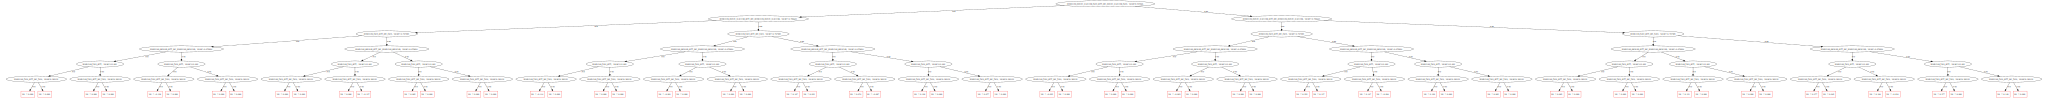

In [89]:
best_model.plot_tree(0,train_pools[np.argmax(validation_scores)])